# BART Simulation Tutorial


**Author**: [Nick Scholand](mailto:scholand@tugraz.at)

**Institution**: Graz University of Technology

This tutorial introduces the Bloch simulation tool `sim` added to the [official BART repository](https://github.com/mrirecon/bart). This tutorial is based on commit `e641e74`, but should be support in all future versions of BART, too. Please contact us, when you experience any issue with this tutorial!

### 0. Setup BART on Google Colab

The cell will setup BART on Google Colab. For a detailed explanation, see **How to Run BART on Google Colaboratory** in the [repository 2021](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021). You can skip this part if you want to run this notebook on Binder or your local machine with BART already installed.

In [ ]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev bc &> /dev/null

# Clone Bart
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

In [ ]:
%%bash

BRANCH=master

cd bart

# Switch to desired branch of the BART project
git checkout -q $BRANCH

# Define specifications 
COMPILE_SPECS="PARALLEL=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

make &> /dev/null

In [ ]:
import os
import sys

# Define environment variables for BART and OpenMP

os.environ['TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

#### Check BART version

Let us check the installed BART version.

In [4]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# The BART used in this notebook:
/home/nick/.bin/bart
# BART version: 
v0.7.00-664-g894b02d


### Functions for Visualization

In [5]:
import sys
import os
sys.path.insert(0, os.path.join(os.environ['TOOLBOX_PATH'], 'python'))
import cfl

import numpy as np
import matplotlib.pyplot as plt

def plot(file, xlabel, ylabel, abs_only=None):
    
    data = cfl.readcfl(file).squeeze()

    if not abs_only:
        plt.plot(np.real(data), 'g.', label="Re(signal)")
        plt.plot(np.imag(data), 'r.', label="Im(signal)")
    
    plt.plot(np.abs(data), 'b.', label="Abs(signal)")

    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend(shadow=True, fancybox=True, fontsize=11)
    
def plot2(file1, file2):
    
    data = cfl.readcfl(file1).squeeze()
    data2 = cfl.readcfl(file2).squeeze()
    
    plt.plot(np.abs(data), 'g.', label="Abs(ODE)")
    plt.plot(np.abs(data2), 'r:', linewidth=3, label="Abs(Analytical)")

    plt.xlabel('repetition $n$ [n*TR]', fontsize=15)
    plt.ylabel('|M$_{xy}$| [a.u.]', fontsize=15)
    plt.legend(shadow=True, fancybox=True, fontsize=11)
    
def imshow(file, ind):
    
    data = np.abs(cfl.readcfl(file).squeeze())
    
    fig, axes = plt.subplots(1, len(ind), figsize=(25, 10))
    
    for i in range(0,len(ind)):
        
        axes[i].imshow(data[:,:,ind[i]], cmap='gray')
        
        axes[i].set_title('Repetition: '+str(ind[i]), fontsize=25)


## Functionallity

The simulation tool is called with

In [6]:
# Overview about the functionality of the sim tool.
! bart sim -h

Usage: sim [-1,--T1 f:f:f] [-2,--T2 f:f:f] [--ROT] [--ODE] [--STM] [--split-dim] [--seq ...] [--other ...] <signal: Mxy> [<Partial derivatives: dR1, dM0, dR2, dB1>] 

simulation tool

-1,--T1 min:max:N    range of T1 values
-2,--T2 min:max:N    range of T2 values
--ROT                homogeneously discretized simulation based on rotational matrices
--ODE                full ordinary differential equation solver based simulation (default)
--STM                state-transition matrix based simulation
--split-dim          Split output in x, y, and z dimensional parts
--seq ...            configure sequence parameter
--other ...          configure other parameters
-h                   help


It is build to support future extensions easily, while having the same basis as the `signal` tool. The generality comes with the introduced `--seq` interface.

In [7]:
# Overview about the functionality of the sim tool.
! bart sim --seq h

Usage of sub-option: --seq [BSSFP],[IR-BSSFP],[FLASH],[IR-FLASH],[TR=f],[TE=f],[Nspins=d],[Nrep=d],[pinv],[ipl=f],[isp=f],[ppl=f],[av-spokes=d],[Trf=f],[FA=f],[BWTP=f],[off=f],[sl-grad=f],[slice-thickness=f]

Sub-options: configure sequence parameter

BSSFP                    bSSFP
IR-BSSFP                 Inversion-Recovery bSSFP
FLASH                    FLASH
IR-FLASH                 Inversion-Recovery FLASH
TR=float                 Repetition time [s]
TE=float                 Echo time [s]
Nspins=int               Number of averaged spins
Nrep=int                 Number of repetitions
pinv                     Use perfect inversions
ipl=float                Inversion Pulse Length [s]
isp=float                Inversion Spoiler Gradient Length [s]
ppl=float                Preparation Pulse Length [s]
av-spokes=               Number of averaged consecutive spokes
Trf=float                Pulse Duration [s]
FA=float                 Flipangle [deg]
BWTP=float               Bandwidth-Time-

## Simulation Examples

### Single Voxel Simulations

An exemplaric simulation call look like

In [8]:
# FLASH simulation
! bart sim --ODE --seq FLASH,TR=0.0041,TE=0.0025,Nrep=1000,ipl=0,ppl=0,Trf=0.001,FA=8,BWTP=4 -1 3:3:1 -2 1:1:1 simu

0.167924


It creates an ODE solver based Bloch simulation of a FLASH sequence

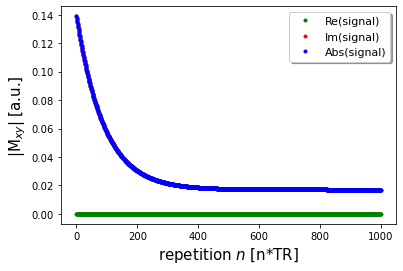

In [9]:
plot('simu', 'repetition $n$ [n*TR]', '|M$_{xy}$| [a.u.]')

with the dimensions

In [10]:
! cat simu.hdr

# Dimensions
1 1 1 1 1 1000 1 1 1 1 1 1 1 1 1 1 
# Command
sim --ODE --seq FLASH,TR=0.0041,TE=0.0025,Nrep=1000,ipl=0,ppl=0,Trf=0.001,FA=8,BWTP=4 -1 3:3:1 -2 1:1:1 simu 
# Files
 >simu
# Creator
BART v0.7.00-664-g894b02d


The time dimension is located in BARTs echo-time dimension (the fifth dimension).

Feel free to play with the parameters in the call above. Here is an additional example for an inversion-recovery bSSFP sequence.

0.195994


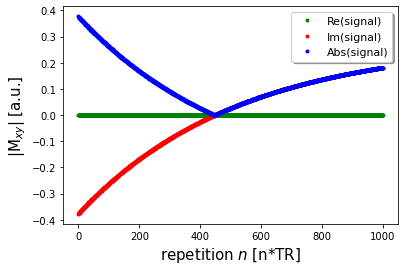

In [11]:
# FLASH simulation
! bart sim --ODE --seq IR-BSSFP,TR=0.0045,TE=0.00225,Nrep=1000,ipl=0,pinv,ppl=0.0225,Trf=0.001,FA=45,BWTP=4 -1 3:3:1 -2 1:1:1 simu
                
plot('simu', 'repetition $n$ [n*TR]', '|M$_{xy}$| [a.u.]')

The `sim` tool follows the `signal` tools convention for simulating various combinations of relaxation parameters:

> $T_1$ and $T_2$ follow with `-1 min:max:#values` and `-2 min:max:#values`

### Comparison to Analytical IR bSSFP Model

The simulation tool is validated for an inversion prepared bSSFP sequence.

Therefore, a single voxel is simulated with `sim` and compared to the result of the analytical `signal` tool output. The theoretical model follows [Schmitt, P. et al. 2004]:

$$S(n\textrm{TR})=S_{stst} - (S_{stst} + S_0)e^{-\frac{n\textrm{TR}}{T_1^*}}.$$

The relaxation parameter follow with
$$
   \begin{align}
		T_1 &= T_1^*\frac{S_0}{S_{stst}}\cos\left(\frac{\alpha}{2}\right),\\
		T_2 &= T_1^*\sin^2\left(\frac{\alpha}{2}\right)\left[1-\frac{S_{stst}}{S_0}\cos\left(\frac{\alpha}{2}\right)\right],~~~\textrm{and}\\
		M_0 &= \frac{S_0}{\sin\left(\frac{\alpha}{2}\right)}.
	\end{align}
$$

0.192077
Spoke Averaging: 1
1.414031
ODE-Analytical Comparison


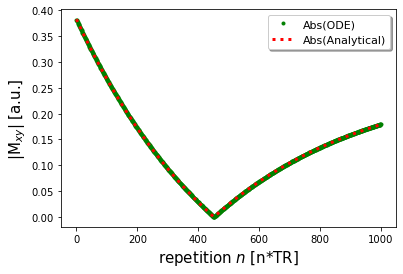

In [12]:
# ODE Simulation with very short pulses (-> close to hard pulses)
! bart sim --ODE --seq IR-BSSFP,TR=0.0045,TE=0.00225,Nrep=1000,ipl=0,pinv,ppl=0.0002,Trf=0.0001,FA=45,BWTP=4 -1 3:3:1 -2 1:1:1 ode
                
                
# Analytical Model
! bart signal -I -B -r0.0045 -e0.00225 -f45 -n1000 -1 3:3:1 -2 1:1:1 signal
                
# Comparison
! bart nrmse signal ode

print("ODE-Analytical Comparison")
plot2('ode', 'signal')

### Off-Resonance

An other supported feature are off-resonance values passed in rad/s. Here, an example for the off-resonance profile of a bSSFP sequence is shown.

In [13]:
%%bash

T1=1.6
T2=0.09
REP=1000
TE=0.00225

Nspins=100

for i in `seq 0 $((Nspins-1))`;
do
    OFF=$(echo $i $Nspins $TE | awk '{printf "%3.6f\n",2*3.1415*1/$3*$1/$2}') # [rad/s]

    bart sim --ODE --seq BSSFP,TR=0.0045,TE=$TE,Nrep=$REP,ipl=0,pinv,ppl=$TE,Trf=0.001,FA=45,BWTP=4,off=$OFF -1 $T1:$T1:1 -2 $T2:$T2:1 sig_$(printf "%03.0f" $i) &>/dev/null
    
    bart slice 5 $((REP-1)) sig_$(printf "%03.0f" $i) sig2_$(printf "%03.0f" $i)
done

rm sig_*.{cfl,hdr}

bart join 6 $(ls sig2_*.cfl | sed -e 's/\.cfl//') data

rm sig2_*.{cfl,hdr}

Off-Resonance Plot


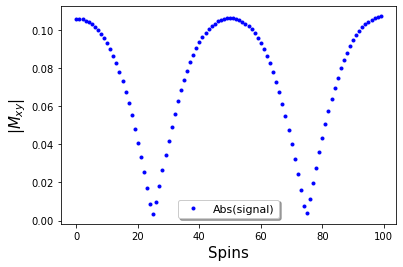

In [14]:
print("Off-Resonance Plot")
plot('data', 'Spins', '$|M_{xy}|$', True)

### Slice-Profile

The simulation tool also supports slice-selection z-gradients passed using the `mom-sl` flag.
It gives the option to simulate full slice-profiles.

In [15]:
%%bash

T1=0.832
T2=0.08
REP=1
TRF=0.001
TE=0.0015
TR=0.003
FA=30
NSPINS=100

G_SS=0.012 # [T/m]
DISTANCE=0.010 # [m]

for i in `seq 0 $((NSPINS-1))`;
do
    Z=$(echo $DISTANCE $i $NSPINS | awk '{printf "%f\n",$1/$3*($2-$3/2)}') # [rad/s]

    TSIM=$(bart sim --ODE --seq FLASH,TR=$TR,TE=$TE,Nrep=$REP,ipl=0,ppl=0,Trf=$TRF,FA=$FA,BWTP=1,slice-thickness=${Z},sl-grad=${G_SS},Nspins=1 -1 $T1:$T1:1 -2 $T2:$T2:1 sig_$(printf "%03.0f" $i))
    
    bart slice 5 $((REP-1)) sig_$(printf "%03.0f" $i) sig2_$(printf "%03.0f" $i)
done

rm sig_*.{cfl,hdr}

bart join 6 $(ls sig2_*.cfl | sed -e 's/\.cfl//') data2

rm sig2_*.{cfl,hdr}

Slice-Profile Plot


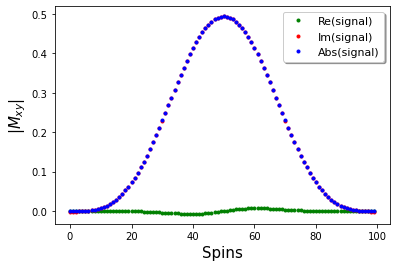

In [16]:
print("Slice-Profile Plot")
plot('data2', 'Spins', '$|M_{xy}|$')

### Synthetic MRI

The `sim` tool can easily be combined with BARTs `phantom` tool. Together, synthetic MRI datasets can be created. In this example a NIST phantom is simulated in k-space using an IR bSSFP sequence.

In [17]:
%%bash

# Simulated Signal

TR=0.0034 #[s]
TE=0.0021 #[s]
REP=600

## Relaxation parameters for NIST phantom
T1=(3 2.48 2.173 1.907 1.604 1.332 1.044 0.802 0.609 0.458 0.337 0.244 0.177 0.127 0.091)
T2=(1 0.581 0.404 0.278 0.191 0.133 0.097 0.064 0.046 0.032 0.023 0.016 0.011 0.008 0.006)

for i in `seq 0 $((${#T1[@]}-1))`;
do
    echo -e "Tube $i\t T1: ${T1[$i]} s,\tT2[$i]: ${T2[$i]} s"

    bart sim --ODE --seq IR-FLASH,TR=$TR,TE=$TE,Nrep=$REP,ipl=0,pinv,ppl=$TE,Trf=0,FA=6,BWTP=4 -1 ${T1[$i]}:${T1[$i]}:1 -2 ${T2[$i]}:${T2[$i]}:1 _basis_simu$(printf "%02d" $i)
done

## Join all individual simulations
bart join 7 $(ls _basis_simu*.cfl | sed -e 's/\.cfl//') _comp_tubes
rm _basis_simu*.{cfl,hdr}

## join them in a single dimension (6)
bart reshape $(bart bitmask 6 7) ${#T1[@]} 1 _comp_tubes comp_simu
rm _comp_tubes.{cfl,hdr}


# Simulated Spatial Basis

DIM=192
GEOM_COMP=${#T1[@]} # Should be 15 for NIST geoemtry
SAMPLES=96
SPOKES=95

## Create trajectory
bart traj -x $((2*SAMPLES)) -y $SPOKES -r _traj

## Scale trajectory for 2-fold oversampling
bart scale 0.5 _traj traj

## Create phantom based on trajectory
bart phantom --NIST -b -k -t traj comp_geom_ksp

## Transform the non-Cartesian k-space samples to image domain
bart nufft -i -d $DIM:$DIM:1 traj comp_geom_ksp comp_geom_img


# Combine simulated Signal and Spatial Basis

bart fmac -s $(bart bitmask 6) comp_geom_img comp_simu phantom_img

Tube 0	 T1: 3 s,	T2[0]: 1 s
0.000997
Tube 1	 T1: 2.48 s,	T2[1]: 0.581 s
0.000991
Tube 2	 T1: 2.173 s,	T2[2]: 0.404 s
0.001000
Tube 3	 T1: 1.907 s,	T2[3]: 0.278 s
0.000991
Tube 4	 T1: 1.604 s,	T2[4]: 0.191 s
0.000993
Tube 5	 T1: 1.332 s,	T2[5]: 0.133 s
0.000991
Tube 6	 T1: 1.044 s,	T2[6]: 0.097 s
0.000995
Tube 7	 T1: 0.802 s,	T2[7]: 0.064 s
0.000986
Tube 8	 T1: 0.609 s,	T2[8]: 0.046 s
0.000991
Tube 9	 T1: 0.458 s,	T2[9]: 0.032 s
0.001010
Tube 10	 T1: 0.337 s,	T2[10]: 0.023 s
0.000992
Tube 11	 T1: 0.244 s,	T2[11]: 0.016 s
0.000992
Tube 12	 T1: 0.177 s,	T2[12]: 0.011 s
0.000998
Tube 13	 T1: 0.127 s,	T2[13]: 0.008 s
0.001177
Tube 14	 T1: 0.091 s,	T2[14]: 0.006 s
0.001457
Done.


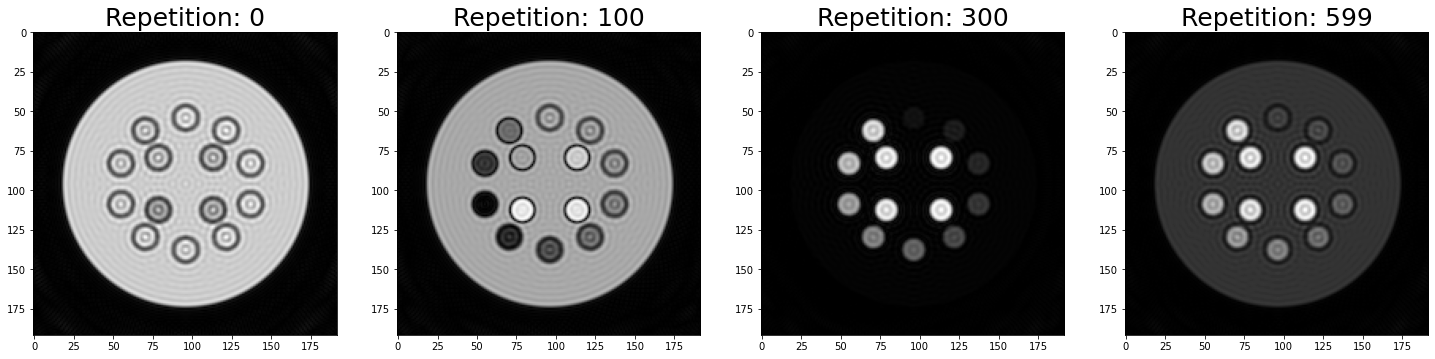

In [18]:
imshow('phantom_img', [0, 100, 300, 599])

### State-Transition Matrices

All simulations presented here are performed with the default ODE solver simulation.
If you want to run **state-transition matrix** based simulations just exchange the `--ODE` flag with the `--STM` flag.

It exploits the repeating patterns in sequences efficiently and reduced the computational costs markedly.

In [19]:
%%bash

# FLASH simulation

# Measure time of ODE simulation

start_time=$(date +%s.%3N)

bart sim --ODE --seq FLASH,TR=0.0041,TE=0.0025,Nrep=3000,ipl=0,ppl=0,Trf=0.001,FA=8,BWTP=4 -1 3:3:1 -2 1:1:1 simu

end_time=$(date +%s.%3N)

TODE=$(echo "$end_time-$start_time" | bc)



# Measure time of STM simulation
start_time2=$(date +%s.%3N)

bart sim --STM --seq FLASH,TR=0.0041,TE=0.0025,Nrep=3000,ipl=0,ppl=0,Trf=0.001,FA=8,BWTP=4 -1 3:3:1 -2 1:1:1 simu

end_time2=$(date +%s.%3N)

TSTM=$(echo "$end_time2-$start_time2" | bc)

# Print Result
echo -e "Elapsed time\nODE: ${TODE} s\tSTM: ${TSTM} s"

0.200206
0.009615
Elapsed time
ODE: .213 s	STM: .019 s


In [3]:
%%bash
rm *.{hdr,cfl}